In [1]:
import pandas as pd

In [2]:
responses = pd.read_csv("responses.csv")
responses.head()

,Participant.ID,Timestamp,Center,Left,Right,Answer,Response.Time..s.,Alg.Label,origTime,origAlg.Label
0,1099,2001-01-01 00:00:00.000001,i0464,i0532,i0546,i0532,7955,Train,31:28.0,Random
1,1099,2001-01-01 00:00:00.000002,i0246,i0386,i0462,i0386,2233,Train,31:28.0,Random
2,1099,2001-01-01 00:00:00.000003,i0524,i0586,i0412,i0586,3627,Test,31:28.0,Test
3,1100,2001-01-01 00:00:00.000004,i0444,i0116,i0034,i0116,1775,Train,36:54.0,Uncertainty
4,1100,2001-01-01 00:00:00.000005,i0308,i0236,i0050,i0236,1445,Train,36:54.0,Uncertainty


In [3]:
random = responses["origAlg.Label"] == "Random"
df = responses.loc[random, ["Center", "Left", "Right", "Answer"]].copy()
df.columns = ["head", "left", "right", "winner"]
for c in df.columns:
    df[c] = df[c].apply(lambda x: int(x.replace("i", "")))
print(df.iloc[0])
df.describe()

head      464
left      532
right     546
winner    532
Name: 0, dtype: int64


,head,left,right,winner
count,7456.000000,7456.000000,7456.000000,7456.000000
mean,300.120172,306.227736,296.472103,306.227736
std,173.144634,160.752340,186.002483,160.752340
min,2.000000,2.000000,2.000000,2.000000
25%,152.000000,174.000000,122.000000,174.000000
50%,300.000000,306.000000,300.000000,306.000000
75%,450.000000,436.000000,468.000000,436.000000
max,600.000000,600.000000,600.000000,600.000000


In [4]:
import numpy as np

def choose_winner(row):
    ldiff = np.abs(row["head"] - row["left"])
    rdiff = np.abs(row["head"] - row["right"])
    if ldiff <= rdiff:
        winner = row["left"]
    else:
        winner = row["right"]
    return winner

df["ground_truth"] = df.apply(choose_winner, axis=1)
ldiff = np.abs(df["head"] - df["left"])
rdiff = np.abs(df["head"] - df["right"])
df["ldiff"] = ldiff
df["rdiff"] = rdiff
df["min_diff"] = np.minimum(ldiff, rdiff)
df["max_diff"] = np.maximum(ldiff, rdiff)
df["ratio"] = df["max_diff"] / (df["max_diff"] + df["min_diff"])
df["correct"] = df["winner"] == df["ground_truth"]
df.head()

,head,left,right,winner,ground_truth,ldiff,rdiff,min_diff,max_diff,ratio,correct
0,464,532,546,532,532,68,82,68,82,0.546667,True
1,246,386,462,386,386,140,216,140,216,0.606742,True
9,356,234,248,234,248,122,108,108,122,0.530435,False
12,294,352,224,352,352,58,70,58,70,0.546875,True
13,40,66,446,66,66,26,406,26,406,0.939815,True


In [5]:
import seaborn as sns

df["ratio_rounded"] = np.round(df["ratio"], decimals=2)
np.unique(np.sort(df["ratio_rounded"]))[-10:]

array([0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.  ])

tanh [9.30738443 0.4567116 ]
sigmoid [19.5269746]


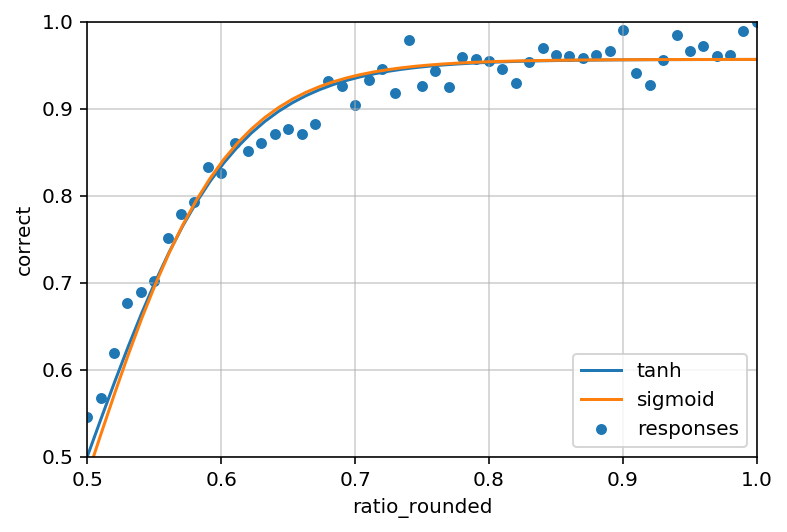

In [22]:
from scipy.optimize import curve_fit

def tanh(x, rate=7.4, final=0.47):
    return final * np.tanh(rate * (x - 0.5)) + 0.5

def sigmoid(x, rate):
    return 0.9567 / (1 + np.exp(-rate * (x - 0.5)))

show = df.pivot_table(
    index="ratio_rounded",
    values="correct",
    aggfunc="mean",
).reset_index()
    

x = show["ratio_rounded"].values
y = show["correct"].values

ax = show.plot.scatter(x="ratio_rounded", y="correct", label="responses")
ax.set_xlim(0.5, 1)
ax.set_ylim(0.5, 1)

for fn in [tanh, sigmoid]:
    popt, pcov = curve_fit(fn, x, y)
    x_show = np.linspace(0.5, 1)
    y_show = fn(x_show, *popt)
    ax.plot(x_show, y_show, label=fn.__name__)
    print(fn.__name__, popt)
ax.legend(loc="best")
ax.grid(alpha=0.6)

So then

$$\mathbb{P}(\text{correct}) = \frac{0.9567}{1 + \exp\left[-19.52697 (r - 0.5) \right]}$$

where $$r = \frac{s_{\max}}{s_{\min} + s_{\max}}$$